<a id='sec0'></a>

# Extracting 2-gram features

The extracted words here will be combined with others extracted in different ways

<a href='#sec1'><b>1. Import and pre-process data</b></a>

<a href='#sec2'><b>2. Create features based on frequency paramerization</b></a>
   
<a href='#sec3'><b>3. PCA & LDA</b></a>

In [1]:
import csv
import json
import random
import re
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import importlib as imp
import feature_engineering.frequency_selection as fefs
import feature_engineering.text_processing as fetp
import myplot.decomposition as mpd

from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


%matplotlib inline

Using TensorFlow backend.
Slow version of gensim.models.doc2vec is being used


<a id='sec1'></a>
# 1. Import and pre-process data
(<a href='#sec0'>Back to top</a>)

In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep=r"\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])
train = class_train.merge(text_train, on='ID')

# create class label container
class_labels = []
for i in range(9):
    class_labels.append('class' + str(i+1))

In [3]:
train[train['Text'] == 'null']

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,null
1277,1277,ARID5B,Truncating Mutations,1,null
1407,1407,FGFR3,K508M,6,null
1639,1639,FLT1,Amplification,6,null
2755,2755,BRAF,G596C,7,null


In [4]:
print('Length of train before removing null entries: %d' % len(train))
train = train.drop(train.index[train['Text'] == 'null'])
print('Length of train before removing null entries: %d' % len(train))

Length of train before removing null entries: 3321
Length of train before removing null entries: 3316


# 1. Test on one piece of text

In [5]:
doc1 = train.iloc[0]['Text']

In [6]:
%%time
tokenized_doc = word_tokenize(fetp.replace_with_whitespace(doc1, hyphens='on'))

stemmer = PorterStemmer()
tokenized_doc = [stemmer.stem(word) for word in tokenized_doc]
processed_doc = [' '.join(tokenized_doc)]

stop_words = set(stopwords.words('english'))
stemmed_stop_words = [stemmer.stem(word) for word in stop_words]

remove_words = ['also', 'anoth', 'case', 'fig', 'gave', 'illustr', 'result', 'show', 'suggest', 'supplementari', 'tabl', 'play', 
                'use', 'pictur', 'could', 'woukd', 'might', 'demonstr', 'whether', 'almost', 'elut', 'find', 'give', 'henc',
                'known', 'ml', 'name', 'ncbi', 'onlin', 'previous', 'purifi', 'method', 'must', 'seem', 'whose', 'when', 'where',
                'this', 'thus', 'town', 'wa', 'wash', 'download', 'yet', 'collect']

CPU times: user 99.5 ms, sys: 976 µs, total: 101 ms
Wall time: 100 ms


In [7]:
# Vectorize without filtering
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
ngram_vectorizer.fit(processed_doc)
ngrams_unfiltered = ngram_vectorizer.get_feature_names()

In [8]:
%%time
ngrams_filtered = []
ngrams_filtered_indices = []
for i, term in enumerate(ngrams_unfiltered):
    word1, word2 = term.split(' ')
    if not (re.search(r'^[A-Za-z]', word1) and re.search(r'^[A-Za-z]', word2)):
        continue
    if not (re.search(r'[A-Za-z0-9]$', word1) and re.search(r'[A-Za-z0-9]$', word2)):
        continue
    if (re.search(r'[@#%&*()+=]', word1) or re.search(r'[@#%&*()+=]', word2)):
        contiue
    if not (len(word1) > 1 or len(word2) > 1):
        continue
    if ((word1.lower() in stemmed_stop_words) or (word2.lower() in stemmed_stop_words)):
        continue
    if ((word1.lower() in remove_words) or (word2.lower() in remove_words)):
        continue
        
    ngrams_filtered.append(term)
    ngrams_filtered_indices.append(i)

print('Before filter: %d terms' % len(ngrams_unfiltered))
print('After filter: %d terms' % len(ngrams_filtered))

Before filter: 3915 terms
After filter: 1306 terms
CPU times: user 29.3 ms, sys: 0 ns, total: 29.3 ms
Wall time: 28.9 ms


# 2. Process the entire text

In [9]:
%%time
stemmer = PorterStemmer()
whole_corpus = []
count = 0
for i in range(len(train)):
    doc = train.iloc[i]['Text']
    tokenized_doc = word_tokenize(fetp.replace_with_whitespace(doc, hyphens='on'))
    tokenized_doc = [stemmer.stem(word) for word in tokenized_doc]
    processed_doc = ' '.join(tokenized_doc)
    if len(processed_doc) < 5:
        print(i)
    whole_corpus.append(processed_doc)
    count += 1
print(count)

3316
CPU times: user 8min 1s, sys: 236 ms, total: 8min 1s
Wall time: 8min 2s


In [10]:
(pd.Series(whole_corpus)).to_csv('./data/unclassified_stemmed_corpus.csv', index=False)

In [11]:
%%time
unfiltered_2gram_words = []
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
ngram_vectorizer.fit(whole_corpus)
unfiltered_2gram_words = ngram_vectorizer.get_feature_names()
unfiltered_2gram_words = list(set(unfiltered_2gram_words))

CPU times: user 41.5 s, sys: 424 ms, total: 41.9 s
Wall time: 41.9 s


In [12]:
%%time
filtered_2gram_words = []
filtered_2gram_words_indices = []
for i, term in enumerate(unfiltered_2gram_words):
    word1, word2 = term.split(' ')
    if not (re.search(r'^[A-Za-z]', word1) and re.search(r'^[A-Za-z]', word2)):
        continue
    if not (re.search(r'[A-Za-z0-9]$', word1) and re.search(r'[A-Za-z0-9]$', word2)):
        continue
    if (re.search(r'[@#%&*()+=]', word1) or re.search(r'[@#%&*()+=]', word2)):
        contiue
    if not (len(word1) > 1 or len(word2) > 1):
        continue
    if ((word1.lower() in stemmed_stop_words) or (word2.lower() in stemmed_stop_words)):
        continue
    if ((word1.lower() in remove_words) or (word2.lower() in remove_words)):
        continue
        
    filtered_2gram_words.append(term)
    filtered_2gram_words_indices.append(i)

print('Before filter: %d terms' % len(unfiltered_2gram_words))
print('After filter: %d terms' % len(filtered_2gram_words))

Before filter: 1875487 terms
After filter: 1023131 terms
CPU times: user 12.7 s, sys: 2 ms, total: 12.7 s
Wall time: 12.7 s


In [13]:
(pd.Series(filtered_2gram_words)).to_csv('./data/filtered_2gram_words.csv', index=False)

Re-vectorize with filtered terms

In [5]:
whole_corpus = (pd.read_csv('./data/unclassified_stemmed_corpus.csv', header=None, squeeze=True)).tolist()
filtered_2gram_words = (pd.read_csv('./data/filtered_2gram_words.csv', header=None, squeeze=True)).tolist()

In [6]:
len(whole_corpus)

3316

In [7]:
%%time
# Vectorizer with the filtered terms
ngram_vectorizer2 = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), vocabulary=filtered_2gram_words)
vectorized_doc = ngram_vectorizer2.fit_transform(whole_corpus)
X = vectorized_doc.toarray()

CPU times: user 29.4 s, sys: 3.77 s, total: 33.2 s
Wall time: 33.2 s


In [11]:
def remove_zero_importance_features(rfc, X, y, print_scores=True,
                            percentile=0.95, test_size=0.15, random_state=None):
    X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=test_size, random_state=random_state)
    rfc.fit(X_train, y_train)
    
    if print_scores:
        print('Accuracy %.3f' % accuracy_score(y_test, rfc.predict(X_test)))
        print('Log Loss %.3f' % log_loss(y_test, rfc.predict_proba(X_test), 
                                         labels=list(range(1, 10))))
    
    imps = rfc.feature_importances_
    selectF_indices = np.argwhere(imps >= np.percentile(imps, 95)).ravel()
    selectX = X[:, selectF_indices]
    
    return selectX

In [12]:
y = np.array(train['Class']).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

In [8]:
n = X.shape[1]
n1 = n // 5
n2 = 2 * n1
n3 = 3 * n1
n4 = 4 * n1

X1 = X[:, :n1]
X2 = X[:, n1:n2]
X3 = X[:, n2:n3]
X4 = X[:, n3:n4]
X5 = X[:, n4:]

In [17]:
%%time
selectX1 = remove_zero_importance_features(rfc, X1, y, random_state=33)
print(X1.shape[1], ' to ', selectX1.shape[1]
np.savetxt('./data/filtered_2gram_tfidf_matrix_split1.csv', selectX1, delimiter=',')
X1 = None

Accuracy 0.629
Log Loss 1.091
204626  to  10232
CPU times: user 6min 25s, sys: 4.35 s, total: 6min 29s
Wall time: 1min 11s


In [19]:
%%time
selectX2 = remove_zero_importance_features(rfc, X2, y, random_state=33)
print(X2.shape[1], ' to ', selectX2.shape[1])
np.savetxt('./data/filtered_2gram_tfidf_matrix_split2.csv', selectX2, delimiter=',')
X2 = None

Accuracy 0.649
Log Loss 1.063
204626  to  10232
CPU times: user 6min 25s, sys: 6.19 s, total: 6min 31s
Wall time: 1min 17s


In [20]:
%%time
selectX3 = remove_zero_importance_features(rfc, X3, y, random_state=33)
print(X3.shape[1], ' to ', selectX3.shape[1])
np.savetxt('./data/filtered_2gram_tfidf_matrix_split3.csv', selectX3, delimiter=',')
X3 = None

Accuracy 0.647
Log Loss 1.073
204626  to  10232
CPU times: user 6min 21s, sys: 5.24 s, total: 6min 26s
Wall time: 1min 14s


In [21]:
%%time
selectX4 = remove_zero_importance_features(rfc, X4, y, random_state=33)
print(X4.shape[1], ' to ', selectX4.shape[1])
np.savetxt('./data/filtered_2gram_tfidf_matrix_split4.csv', selectX4, delimiter=',')
X4 = None

Accuracy 0.627
Log Loss 1.088
204626  to  10232
CPU times: user 6min 6s, sys: 5.93 s, total: 6min 12s
Wall time: 1min 14s


In [22]:
%%time
selectX5 = remove_zero_importance_features(rfc, X5, y, random_state=33)
print(X5.shape[1], ' to ', selectX5.shape[1])
np.savetxt('./data/filtered_2gram_tfidf_matrix_split5.csv', selectX5, delimiter=',')
X5 = None

Accuracy 0.665
Log Loss 1.065
204627  to  10232
CPU times: user 6min 16s, sys: 6.92 s, total: 6min 23s
Wall time: 1min 18s


In [23]:
X = None

In [29]:
selectX = np.concatenate(
                (selectX1, selectX2, selectX3, selectX4, selectX5), 
                axis=1)
print(selectX.shape)

(3316, 51160)


In [30]:
%%time
y = np.array(train['Class']).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = \
                train_test_split(selectX, y, test_size=0.15, random_state=345)
rfc.fit(X_train, y_train)

print('Accuracy %.3f' % accuracy_score(y_test, rfc.predict(X_test)))
print('Log Loss %.3f' % log_loss(y_test, rfc.predict_proba(X_test), 
                                 labels=list(range(1, 10))))

Accuracy 0.665
Log Loss 0.998
CPU times: user 1min 18s, sys: 908 ms, total: 1min 19s
Wall time: 15.2 s


In [36]:
y = np.array(train['Class']).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

selectX1 = remove_zero_importance_features(rfc, selectX, y, print_scores=True,
                            percentile=0.99, test_size=0.15, random_state=345)
print(selectX1.shape)

Accuracy 0.665
Log Loss 0.998
(3316, 2558)


# PCA & LDA

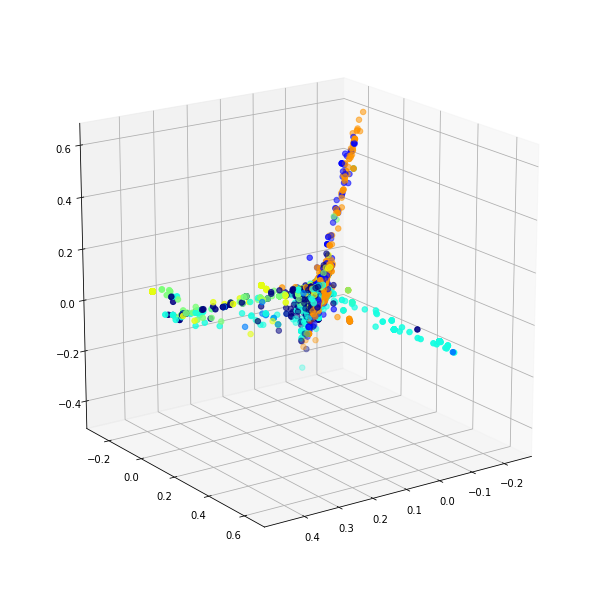

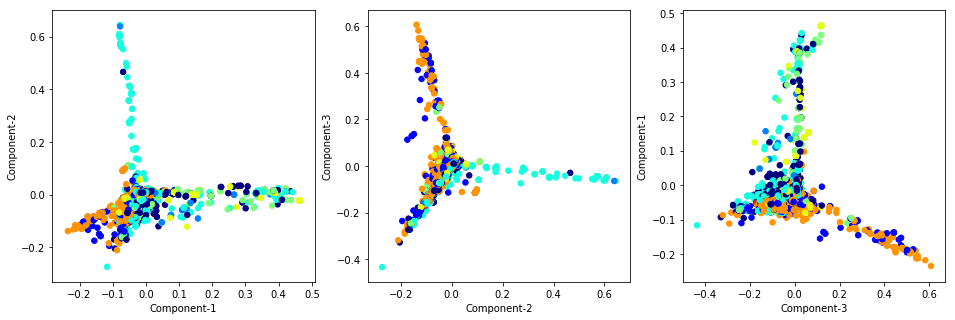

In [37]:
decomp_table = mpd.decomposition3D(selectX1, train['Class'])
mpd.decomposition3DPlot(decomp_table, train['Class'])
mpd.decomposition2DPlot(decomp_table, train['Class'])

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CPU times: user 16.6 s, sys: 85.9 ms, total: 16.7 s
Wall time: 16.7 s


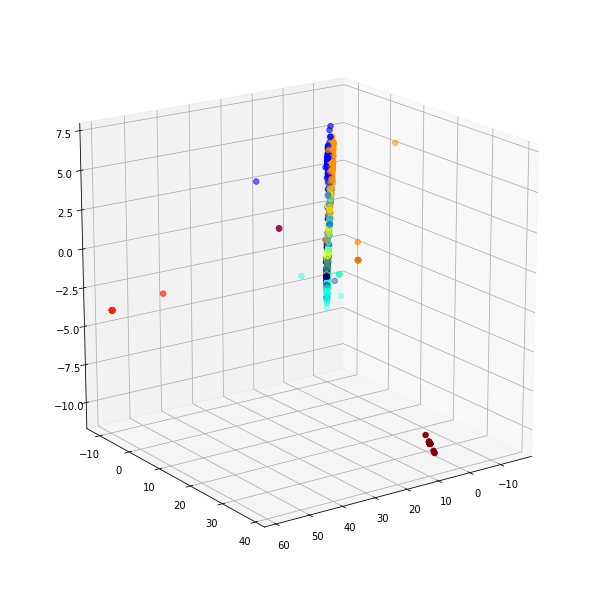

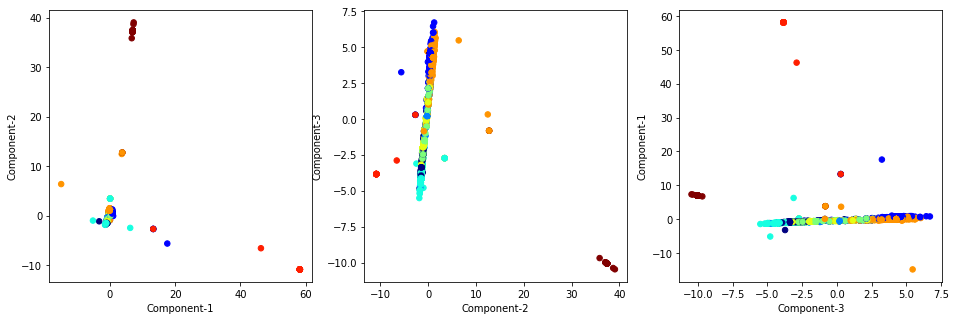

In [39]:
%%time
decomp_table = mpd.decomposition3D(selectX1, train['Class'], 
                y=y, decomposer=LinearDiscriminantAnalysis(n_components=3))
mpd.decomposition3DPlot(decomp_table, train['Class'])
mpd.decomposition2DPlot(decomp_table, train['Class'])

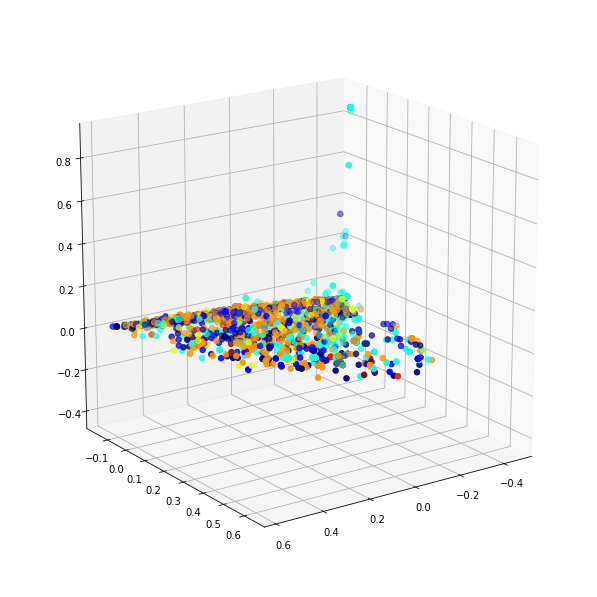

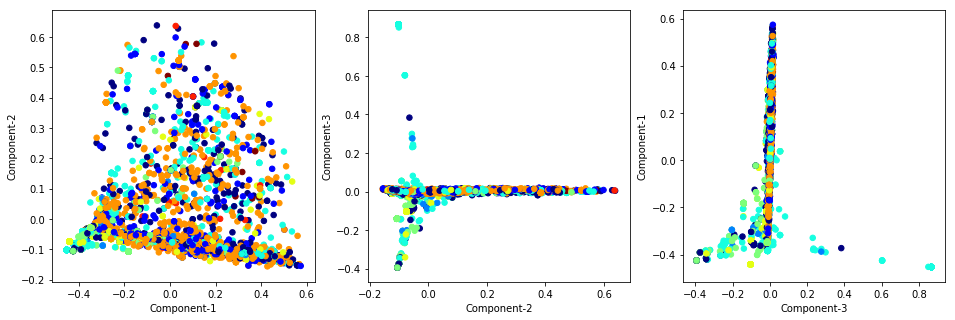

In [49]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel="rbf", gamma=10, n_components=3, n_jobs=8)
decomp_table = mpd.decomposition3D(selectX1, train['Class'], 
                                y=y, decomposer=kpca)
mpd.decomposition3DPlot(decomp_table, train['Class'])
mpd.decomposition2DPlot(decomp_table, train['Class'])